In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os

from hist_info_extractor import ExtractHistData

from coffea.util import load

In [2]:
cms_color = {
    "blue": "#3f90da",
    "orange": "#ffa90e",
    "red": "#bd1f01",
    "gray": "#94a4a2",
    "purple": "#832db6",
    "brown": "#a96b59",
    "dark_orange": "#e76300",
    "beige": "#b9ac70",
    "dark_gray": "#717581",
    "light_blue": "#92dadd"
}

In [10]:
class Plotter:
    def __init__(self, hist_info):
        self.hist_info = hist_info
        self.colors = [cms_color["orange"], cms_color["purple"], cms_color["red"],
                       cms_color["beige"], cms_color["blue"], cms_color["dark_gray"],
                       cms_color["light_blue"], cms_color["brown"], cms_color["dark_orange"], cms_color["gray"]]

    def define_figure(self):
        self.fig, (self.ax, self.rax) = plt.subplots(
            2, 1, figsize=(10, 8), 
            gridspec_kw={"height_ratios": [3, 1], "hspace": 0.0}, 
            sharex=True
        )
        # self.fig, self.ax = plt.subplots(
        #     1, figsize=(10, 8)
        # )

    def plot_datamc(self):
        
        bottom = np.zeros(len(self.hist_info.bin_centers))
        for i, (name, values) in enumerate(self.hist_info.backgrounds.items()):
            self.ax.bar(
                self.hist_info.bin_centers, values, width=self.hist_info.bin_widths,
                bottom=bottom, alpha=0.8, label=name, color=self.colors[i],
                edgecolor='black', linewidth=0.5
            )
            bottom += values
            
        self.ax.errorbar(
            self.hist_info.bin_centers, self.hist_info.data, yerr=self.hist_info.stat,
            fmt='o', color='black', markersize=5, capsize=0,
            linewidth=2, label='Data'
        )
        
        for i, (name, values) in enumerate(self.hist_info.signals.items()):
            self.ax.step(
                self.hist_info.bins, np.append(values, values[-1]), where='post',
                alpha=1, linestyle="dashed", label=name, color=self.colors[i], linewidth=2
            )
        
        lower = self.hist_info.total_backgrounds - self.hist_info.syst
        upper = self.hist_info.total_backgrounds + self.hist_info.syst
        self.ax.fill_between(
            self.hist_info.bins,
            np.append(lower, lower[-1]),
            np.append(upper, upper[-1]),
            step='post', facecolor="None", alpha=0.9, hatch='////',
            label="stat unc.", edgecolor='black', linewidth=0
        )
        
        # cats = {"emu": "$e\mu$", "ee": "$ee$", "mumu": "$\mu\mu$"}
        # self.ax.text(0.75, 0.45, cats[channel], transform=self.ax.transAxes, 
        #        fontsize=20, fontweight='bold', va='top')
        
        self.ax.set_ylabel('Events', fontsize=15)
        self.ax.minorticks_on()
        self.ax.legend(fontsize=10, loc='best')
        self.ax.grid(True, alpha=0.3)
        # self.ax.set_title(f'Normalized differential cross section/{self.x_axis_name}', fontsize=16)
    
    def plot_ratio(self):
        ratio = self.hist_info.data / self.hist_info.total_backgrounds
        ratio_err = self.hist_info.stat / self.hist_info.total_backgrounds

        # Plot ratio
        self.rax.errorbar(self.hist_info.bin_centers, ratio, yerr=ratio_err, 
                          fmt='o', color='black', markersize=5, linewidth=1.5,
                          capsize=0, capthick=1.5, label='Data/MC')

        self.rax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5)

        syst_unc_ratio = self.hist_info.syst / self.hist_info.total_backgrounds
        lower = 1 - syst_unc_ratio
        upper = 1 + syst_unc_ratio
        self.rax.fill_between(self.hist_info.bins, np.append(lower, lower[-1]), np.append(upper, upper[-1]),
                 step='post', facecolor="None", alpha=0.9, hatch='////',
                 label='Syst. Unc.', edgecolor='black', linewidth=0)

        # Set labels and limits
        self.rax.set_xlabel(self.hist_info.ax_label, fontsize=15)
        self.rax.set_ylabel('Data/MC')
        self.rax.set_ylim(0.5, 2)
        self.rax.set_xlim(self.hist_info.bins[0], self.hist_info.bins[-1])
        self.rax.grid(True, alpha=0.3)
        self.rax.set_xlim(self.ax.get_xlim())

        # Add bin edges as x-ticks
        # ax_bottom.set_xticks(bins)
    
    def plot_histogram(self):
        self.define_figure()
        self.plot_datamc()
        self.plot_ratio()

        os.makedirs(f"plots/{self.hist_info.cat}", exist_ok=True)
        plt.savefig(f"plots/{self.hist_info.cat}/{self.hist_info.var_name}.png", dpi=300, bbox_inches="tight")
        # plt.savefig(f"plots/{name}.pdf", bbox_inches="tight")
        plt.close()

    
        

In [15]:
mc_backgrounds1 = {
    r"Single-t+$\gamma$":["TGJets", "ST"],
    r"$\gamma Jets$": ["GJets"],
    "diBoson": ["ZZ", "WW", "WZ"],
    r"VV$\gamma$": ["WWG", "WZG", "ZZG"],
    r"$t\bar{t}\gamma$": ["TTG"],
    # r"$t\bar{t}$": ["TT"],
    r"$W\gamma Jets$": ["WJets", "WG"],
    r"$Z\gamma$": ["DYJets", "ZG"]
}
mc_backgrounds2 = {
    r"Single-t+$\gamma$":["TGJets", "ST"],
    r"$\gamma Jets$": ["GJets"],
    "diBoson": ["ZZ", "WW", "WZ"],
    r"VV$\gamma$": ["WWG", "WZG", "ZZG"],
    r"$t\bar{t}\gamma$": ["TTG"],
    r"$t\bar{t}$": ["TT"],
    r"$W\gamma Jets$": ["WJets", "WG"],
    r"$Z\gamma$": ["DYJets", "ZG"]
}
data = {
    2016: ["DATA_SingleElectron"],
    2017: ["DATA_SingleElectron"],
    2018: ["DATA_EGamma"],
}
dd_backgrounds = {
    r"$Jets\rightarrow\gamma$": data
}
signals = [
    # "Signal_600",
    # "Signal_700",
    # "Signal_800",
    # "Signal_900",
    "Signal_1000",
    # "Signal_1100",
    # "Signal_1200",
    # "Signal_1300",
    # "Signal_1400",
    "Signal_1500",
    # "Signal_1600",
    # "Signal_1700",
    # "Signal_1800",
    # "Signal_1900",
    "Signal_2000",
]

In [16]:
from pathlib import Path
import sys
current_dir = Path().cwd()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))
from ele_config import cfg
from workflow import TopPartnerBaseProcessor   

def run_postprocessor(output):
        
    cfg.load()
    tpp = TopPartnerBaseProcessor(cfg)
    # print(cfg.filesets)
    return tpp.postprocess(output)

In [17]:
output = load("output.coffea")

/tmp/ipykernel_1960/865426693.py:62: RuntimeWarning: invalid value encountered in divide
  ratio = self.hist_info.data / self.hist_info.total_backgrounds
/tmp/ipykernel_1960/865426693.py:63: RuntimeWarning: invalid value encountered in divide
  ratio_err = self.hist_info.stat / self.hist_info.total_backgrounds
/tmp/ipykernel_1960/865426693.py:72: RuntimeWarning: invalid value encountered in divide
  syst_unc_ratio = self.hist_info.syst / self.hist_info.total_backgrounds


ValueError: 'x' and 'y' must have the same size

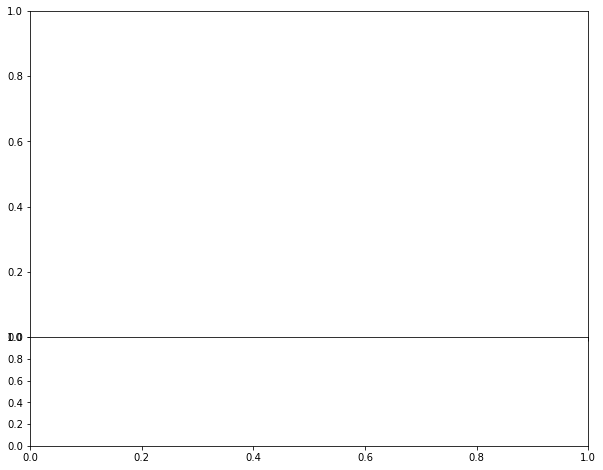

In [18]:
if not output["datasets_metadata"]:
    output = run_postprocessor(output)

for variable in output["variables"]:
    for cat in ["SR", "CRB", "CRC", "CRD", "PLJ", "b0_SR", "b0_CRB", "b0_CRC", "b0_CRD", "b0_PLJ"]:
        if "SR" in cat:
            extractor = ExtractHistData(output, 2018)
            hist_data = extractor.extract_hist_info(variable, cat, data=data, signals=signals, MC_BCs=mc_backgrounds1, **dd_backgrounds)
        else: # cat in ["CRB", "CRC", "CRD", "PLJ"]:
            extractor = ExtractHistData(output, 2018)
            hist_data = extractor.extract_hist_info(variable, cat, data=data, signals=signals, MC_BCs=mc_backgrounds2)
        plotter = Plotter(hist_data)
        plotter.plot_histogram()

In [10]:
if not output["datasets_metadata"]:
    output = run_postprocessor(output)
    
extractor = ExtractHistData(output, 2018)
hist_data = extractor.extract_hist_info("photon_pt", "SR", data=data, MC_BCs=mc_backgrounds1, **dd_backgrounds)